In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

In [21]:
def divided_difference(step, y1, y2):
    return (y2 - y1)/step

In [22]:
def calculate_population(year):
    this_population = 0
    for i in range(Newton_koefs.size):
        smth_in_brackets = Newton_koefs[i]
        for j in range(i):
            smth_in_brackets *= (year - (start_year + step_in_years * j))
        this_population += smth_in_brackets
    return this_population

In [23]:
population = np.array([92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203211926, 226545805, 248709873, 281421906])
step_in_years = 10
start_year = 1910
end_year = 2000

In [24]:
Newton_koefs = np.zeros(population.size)

this_iter = population.copy();
for i in range(population.size):
    Newton_koefs[i] = this_iter[0]
    next_iter = np.zeros(this_iter.size - 1)
    for j in range(next_iter.size):
        next_iter[j] = divided_difference(step_in_years * (i + 1), this_iter[j], this_iter[j + 1])
    this_iter = next_iter.copy()

In [25]:
print(Newton_koefs)

[ 9.22284960e+07  1.37930410e+06  1.69402300e+04 -1.93453133e+03
  1.25106725e+02 -4.15059800e+00  8.05654167e-02 -7.56485278e-04
 -7.56467535e-06  5.09932804e-07]


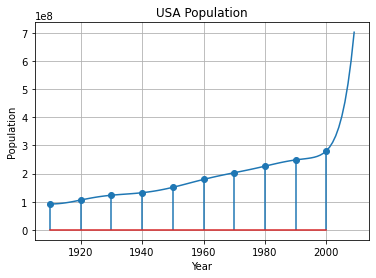

In [26]:
years_for_graphic = np.arange(1910, 2010, 1)
population_for_graphic = calculate_population(years_for_graphic)

plt.plot(years_for_graphic, population_for_graphic)
plt.stem(np.arange(1910, 2001, 10), population)
plt.grid()
plt.title("USA Population")
plt.ylabel("Population")
plt.xlabel("Year")
plt.show()

Модель не подходит для экстраполяции за пределы интервала данных точек

Для кубического сплайна (краевые условия s"(1910) = 0 и s"(2000) = 0) составим 3-диагональную матрицу A (на деле матрица A умножена на 6 для удобства) (см. семинар)

In [27]:
m_size = population.size
A = np.zeros(shape = [m_size, m_size])
f = np.zeros(m_size)

for i in range(1, f.size - 1):
    f[i] = 6 * (population[i - 1] - 2 * population[i] + population[i + 1]) / step_in_years
    
A[0, 0] = 1
A[-1, -1] = 1
for i in range(1, m_size - 1):
    A[i, i - 1] = step_in_years
    A[i, i] = 4 * step_in_years
    A[i, i + 1] = step_in_years

print("Матрица A (умноженная на 6 для удобства):\n", A)

Матрица A (умноженная на 6 для удобства):
 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [10. 40. 10.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10. 40. 10.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 10. 40. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 10. 40. 10.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10. 40. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 10. 40. 10.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 10. 40. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 10. 40. 10.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


Для нахождения c_i из системы Ac = f воспользуемся методом прогонки (т.к. матрица 3-диагональная):

In [28]:
def run_through(A, f):
    n = len(A)
    x = [0 for k in range(0, n)] # обнуление вектора решений
    print('Размерность матрицы: ',n,'x',n)
    
    # Прямой ход
    v = [0 for k in range(0, n)]
    u = [0 for k in range(0, n)]
    # для первой 0-й строки
    v[0] = A[0][1] / (-A[0][0]) 
    u[0] = ( - f[0]) / (-A[0][0]) 
    for i in range(1, n - 1): # заполняем за исключением 1-й и (n-1)-й строк матрицы
        v[i] = A[i][i+1] / ( -A[i][i] - A[i][i-1]*v[i-1] )
        u[i] = ( A[i][i-1]*u[i-1] - f[i] ) / ( -A[i][i] - A[i][i-1]*v[i-1] )
    # для последней (n-1)-й строки
    v[n-1] = 0
    u[n-1] = (A[n-1][n-2]*u[n-2] - f[n-1]) / (-A[n-1][n-1] - A[n-1][n-2]*v[n-2])
    
    # Обратный ход
    x[n-1] = u[n-1]
    for i in range(n-1, 0, -1):
        x[i-1] = v[i-1] * x[i] + u[i-1]
        
    return x    

Найдём коэффициенты в сплайне:

In [29]:
c = np.array(run_through(A, f))
print("c = ", c)

a = np.zeros(m_size)
b = np.zeros(m_size)
d = np.zeros(m_size)

a[0] = population[0]
b[0] = population[0] / step_in_years + c[0] / 3 * step_in_years
d[0] = c[0] / step_in_years
for i in range(1, m_size):
    a[i] = population[i]
    b[i] = (population[i] - population[i - 1]) / step_in_years + (2 * c[i] + c[i - 1]) / 6 * step_in_years
    d[i] = (c[i] - c[i - 1]) / step_in_years

Размерность матрицы:  10 x 10
c =  [      0.           98565.08103441 -190977.56413762  172196.65551609
  114147.98207325  -98619.7038091    33813.27316315  -69925.70884351
  175700.90221088      -0.        ]


Функция для вычисления значения сплайна в точке:

In [30]:
def population_by_spline(year):
    i = math.floor((year - (start_year - step_in_years)) / step_in_years)
    if i == a.size:
        i = a.size - 1
    year_i = start_year + i * step_in_years
    return a[i] + b[i] * (year - year_i) + c[i] / 2 * (year - year_i) ** 2 + d[i] / 6 * (year - year_i) ** 3

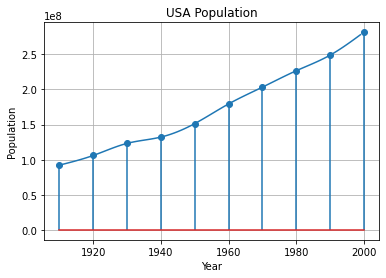

In [31]:
years_for_graphic = np.arange(start = 1910, stop = 2000, step = 1)
population_for_graphic = np.zeros(years_for_graphic.size)
for i in range(years_for_graphic.size):
    population_for_graphic[i] = population_by_spline(years_for_graphic[i])

plt.plot(years_for_graphic, population_for_graphic)
plt.stem(np.arange(start = 1910, stop = 2001, step = 10), population)
plt.grid()
plt.title("USA Population")
plt.ylabel("Population")
plt.xlabel("Year")
plt.show()

Для экстраполяции продолжим последний отрезок сплайна до 2010 года:

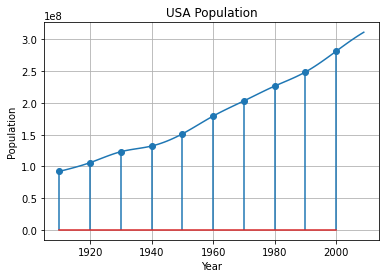

In [33]:
years_for_graphic = np.arange(start = 1910, stop = 2010, step = 1)
population_for_graphic = np.zeros(years_for_graphic.size)
for i in range(years_for_graphic.size):
    population_for_graphic[i] = population_by_spline(years_for_graphic[i])

plt.plot(years_for_graphic, population_for_graphic)
plt.stem(np.arange(start = 1910, stop = 2001, step = 10), population)
plt.grid()
plt.title("USA Population")
plt.ylabel("Population")
plt.xlabel("Year")
plt.show()

По экстраполированным данным численность населения в 2010 году:

In [34]:
print(math.floor(population_for_graphic[-1]))

311363483


Численность согласно табличным данным:

308745538

Оценка с помощью экстраполяции близка к действительности